In [ ]:
!sudo apt -y install libportaudio2
!pip install tflite-model-maker

In [ ]:
import os
import random
import soundfile as sf
from IPython.display import Audio
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tflite_model_maker import audio_classifier

TensorFlow Version: 2.8.2
Model Maker Version: 0.4.1


In [ ]:
tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182091776/182082353 [==============================] - 1s 0us/step


'./data/mini_speech_commands.zip'

In [ ]:
!unzip -q data/mini_speech_commands.zip -d data_set/ 

In [ ]:
yes_ds_dir = 'data_set/mini_speech_commands/yes/'
no_ds_dir = 'data_set/mini_speech_commands/no/'
yes_wav = [f for f in os.listdir(yes_ds_dir) if f.endswith('.wav')]
no_wav = [f for f in os.listdir(no_ds_dir) if f.endswith('.wav')]
files_list = []

for i in range(1000):
  files_list.append(os.path.join(yes_ds_dir, yes_wav[i]))
for i in range(1000):
  files_list.append(os.path.join(no_ds_dir, no_wav[i]))

2000


In [ ]:
def get_random_audio_file():
  random_audio_path = random.choice(files_list)
  return random_audio_path
  
def show_sample(audio_path):
  audio_data, sample_rate = sf.read(audio_path)
  class_name = os.path.basename(os.path.dirname(audio_path))
  print(f'Class: {class_name}')
  print(f'File: {audio_path}')
  print(f'Sample rate: {sample_rate}')
  print(f'Sample length: {len(audio_data)}')

  plt.title(class_name)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

Class: yes
File: data_set/mini_speech_commands/yes/8d8d9855_nohash_0.wav
Sample rate: 16000
Sample length: 16000


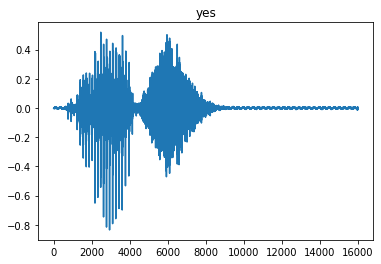

In [ ]:
random_audio = get_random_audio_file()
show_sample(random_audio)

In [ ]:
spec = audio_classifier.BrowserFftSpec()

INFO:tensorflow:Checkpoints are stored in /tmp/tmpr3ey9xb2
32768/18467 [=====================================================] - 0s 0us/step
16384/203 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
data = audio_classifier.DataLoader.from_folder(spec, './data_set/mini_speech_commands/',categories=['yes','no'], shuffle=True, cache=True)
train_data, rest_data = data.split(0.6)
validation_data, test_data = rest_data.split(0.5)

In [ ]:
# If your dataset has fewer than 100 samples per class,
# you might want to try a smaller batch size
batch_size = 6
epochs = 10
model = audio_classifier.create(train_data, spec, validation_data, batch_size, epochs)
history = model.train(train_data, validation_data, batch_size, epochs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 42, 225, 8)        136       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 112, 8)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 109, 32)       2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 51, 32)         8224      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 25, 32)       

Text(0.5, 0, 'epoch')

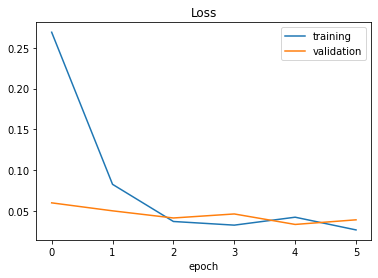

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

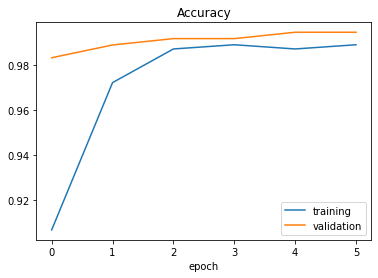

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

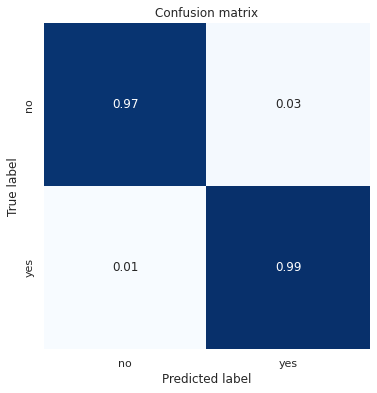

In [ ]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  sns.set(rc = {'figure.figsize':(6,6)})
  sns.heatmap(
      confusion_normalized, xticklabels=test_labels, yticklabels=test_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True, cbar=False)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)